<a href="https://colab.research.google.com/github/EstebanPiacentino/GAN4DataAnonymization/blob/master/GAN_with_PyTorch_Cardio_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
cd /gdrive/My Drive/Colab Notebooks

/gdrive/My Drive/Colab Notebooks


In [0]:
#Dependencies
import numpy as np
import pandas as pd
import os
from skimage import io, transform
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from random import choice
import ast

from zipfile import ZipFile
import io as ios

In [0]:
#dataFile=pd.read_csv('tyroid_clean.csv')
#binaryVars=['Sex','On_thyroxine','Query_on_thyroxine','On_antithyroid_medication','Sick','Pregnant','Thyroid_surgery','I131_treatment','Query_hypothyroid','Query_hyperthyroid','Lithium','Goitre','Tumor','Hypopituitary','Psych']
#continuousVars=['Age','TSH','T3','TT4','T4U','FTI']
#
#row=12
#
#print(len(dataFile))
#
#cont_data_sample=dataFile.loc[row,continuousVars].values
#binary_data_sample=dataFile.loc[row,binaryVars].values
#
#cont_data_sample_bloc=np.reshape(cont_data_sample,(2,3)) #With .T we can transpose it
#binary_data_sample_bloc=np.reshape(binary_data_sample,(5,3))
#
#print(cont_data_sample)
#print(binary_data_sample)
#
#sample_bloc=np.concatenate((cont_data_sample_bloc,binary_data_sample_bloc))
#extra_bloc=np.zeros((7,4))
#
#sample_bloc=np.concatenate((sample_bloc,extra_bloc), axis=1)
#
#plt.axis('off')
#plt.grid(b=None)
#
#im=plt.imshow(sample_bloc)

#Inverse transformation
#print(np.reshape(sample_bloc[:2,:3],(6)))
#print(np.reshape(sample_bloc[2:,:3],(15)))



In [0]:
class TyroidDataset(Dataset):
    """Fingerprints dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.archive = pd.read_csv(self.root_dir)
        self.binaryVars=['Sex','On_thyroxine','Query_on_thyroxine','On_antithyroid_medication','Sick','Pregnant','Thyroid_surgery','I131_treatment','Query_hypothyroid','Query_hyperthyroid','Lithium','Goitre','Tumor','Hypopituitary','Psych']
        self.continuousVars=['Age','TSH','T3','TT4','T4U','FTI']

    def __len__(self):
        return 6330 #Total number of images

    def __getitem__(self, idx):
        cont_data_sample=self.archive.loc[idx,self.continuousVars].values
        binary_data_sample=self.archive.loc[idx,self.binaryVars].values
        
        cont_data_sample_bloc=np.reshape(cont_data_sample,(2,3)) #With .T we can transpose it
        binary_data_sample_bloc=np.reshape(binary_data_sample,(5,3))
        
        sample_bloc=np.concatenate((cont_data_sample_bloc,binary_data_sample_bloc))
        extra_bloc=np.zeros((7,4))
        
        sample_bloc=np.uint8(np.concatenate((sample_bloc,extra_bloc), axis=1))
        
        image = sample_bloc #io.imread(sample_bloc)

        if self.transform:
            image = self.transform(image)

        return image

In [0]:
class CardioDataset(Dataset):
    """Fingerprints dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.archive = pd.read_csv(self.root_dir, index_col=0)

    def __len__(self):
      return 28902 #Total number of images

    def __getitem__(self, idx):
        sample=ast.literal_eval(self.archive.loc[idx,'signal'])[:2025]
        #sample=[self.remap(x,sample) for x in sample]
        sample=np.reshape(sample,(45,45))
        sample_bloc=np.uint8(sample)
        image = sample_bloc 

        if self.transform:
            image = self.transform(image)

        return image
    
    def remap(self,x,sample):
        A=min(sample)
        B=max(sample)
        C=0
        D=255
        
        out=(x-A)/(B-A)*(D-C)+C
        return int(out)

In [0]:
#Load
out_dir = './Fingerprints_dataset' #saves dataset here
transform =  transforms.Compose([transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))])
#download MNIST, save and apply transform 
cardio_data =  CardioDataset(root_dir='output_cardio_db_remapped.csv', transform=transform)
#Data loader feeds data as inputs and labels, of fixed batch size
train_loader = torch.utils.data.DataLoader(cardio_data, batch_size = 52, shuffle = True)

In [0]:
#Get Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
#Define discriminator
def disc_model():
    discriminator_model = nn.Sequential(
      nn.Linear(45*45, 1024),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(1024, 512),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(512, 256),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.3),
      nn.Linear(256, 1),
      nn.Sigmoid()
      ).to(device)
    return discriminator_model
#create a discriminator network
discriminator = disc_model()
#if we want to start from a checkpoint model
discriminator.load_state_dict(torch.load('DataOutput/f_name_RawData.pth')['dis_state_dict'])
discriminator.eval()

Sequential(
  (0): Linear(in_features=2025, out_features=1024, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Dropout(p=0.3)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): LeakyReLU(negative_slope=0.2)
  (5): Dropout(p=0.3)
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Dropout(p=0.3)
  (9): Linear(in_features=256, out_features=1, bias=True)
  (10): Sigmoid()
)

In [0]:
#Define generator
def gen_model():
    generator_model = nn.Sequential(
          nn.Linear(100, 256),
          nn.LeakyReLU(0.2),
          nn.Linear(256 , 512),
          nn.LeakyReLU(0.2),
          nn.Linear(512 , 1024),
          nn.LeakyReLU(0.2),
          nn.Linear(1024 , 45*45),
          nn.Tanh()    
          ).to(device)
    return generator_model
#create a generator network
generator = gen_model()
#if we want to start from a checkpoint model
generator.load_state_dict(torch.load('DataOutput/f_name_RawData.pth')['gen_state_dict'])
generator.eval()

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=512, out_features=1024, bias=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): Linear(in_features=1024, out_features=2025, bias=True)
  (7): Tanh()
)

In [0]:
#Noise generator
from torch.autograd import Variable
def rand_vecs(batch_size):
    return Variable(torch.randn(batch_size, 100)).to(device)

In [0]:
#Define optimizer and loss criterion
import torch.optim as optim
#create separate optimizers, use BCELoss for both networks
d_optimizer = optim.Adam(discriminator.parameters(), lr = 0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr = 0.0002)
criterion = nn.BCELoss()

In [0]:
#Get the labels
def ones_or_zeros(batch_size, labels):
    if labels == 1:
        return Variable(torch.ones(batch_size, 1)).to(device)
    elif labels == 0:
        return Variable(torch.zeros(batch_size, 1)).to(device)

torch.Size([1, 45, 45])


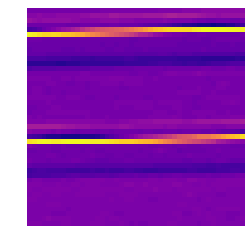

In [0]:
#Check ground truth sample:
for inputs in train_loader:
  print(inputs[0].shape)
  sample=inputs[0].view(-1, 45).detach().numpy()
  plt.axis('off')
  plt.grid(b=None)
  im=plt.imshow(sample)
  im.set_cmap('plasma')
  break

 100.0% Epoch passedNew epoch: 102
 100.0% Epoch passedNew epoch: 103
 100.0% Epoch passedNew epoch: 104
 100.0% Epoch passedNew epoch: 105
 100.0% Epoch passedloss_disc:1.86835.., loss_generator: 0.63695


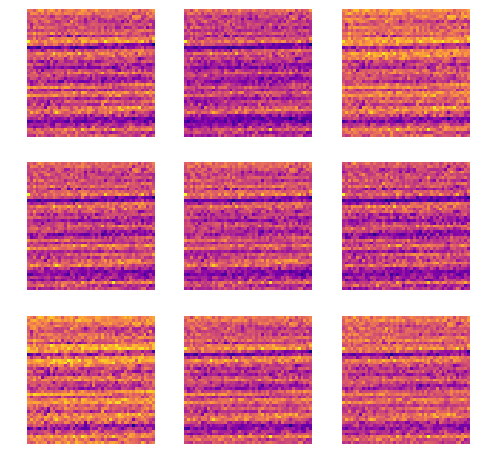

 100.0% Epoch passedNew epoch: 107
 100.0% Epoch passedNew epoch: 108
 100.0% Epoch passedNew epoch: 109
 100.0% Epoch passedNew epoch: 110
 100.0% Epoch passedloss_disc:1.69257.., loss_generator: 0.97178


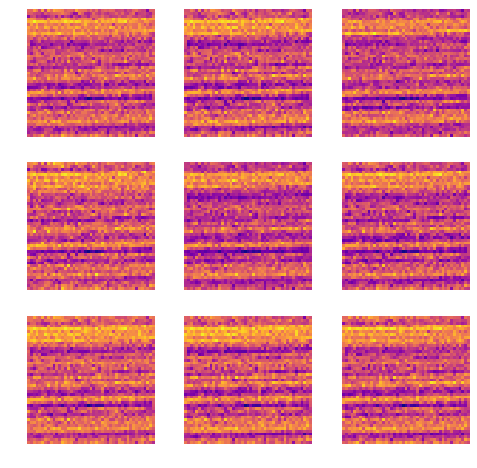

 100.0% Epoch passedNew epoch: 112
 100.0% Epoch passedNew epoch: 113
 100.0% Epoch passedNew epoch: 114
 100.0% Epoch passedNew epoch: 115
 100.0% Epoch passedloss_disc:1.35506.., loss_generator: 1.0529


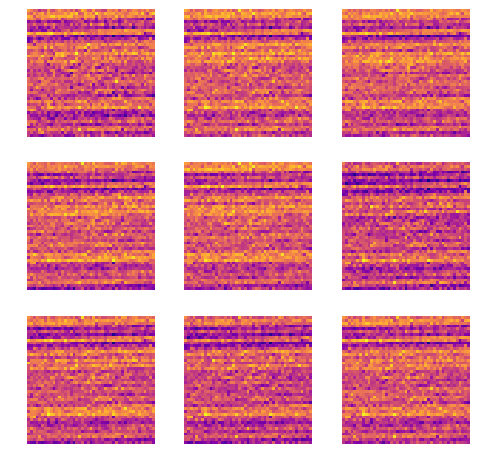

 100.0% Epoch passedNew epoch: 117
 100.0% Epoch passedNew epoch: 118
 100.0% Epoch passedNew epoch: 119
 100.0% Epoch passedNew epoch: 120
 100.0% Epoch passedloss_disc:1.26885.., loss_generator: 0.93671


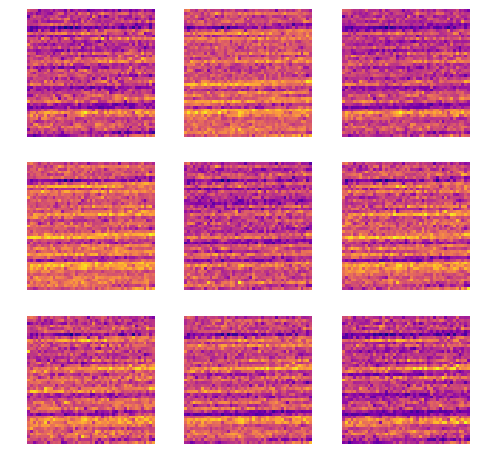

 100.0% Epoch passedNew epoch: 122
 100.0% Epoch passedNew epoch: 123
 100.0% Epoch passedNew epoch: 124
 100.0% Epoch passedNew epoch: 125
 100.0% Epoch passedloss_disc:1.20489.., loss_generator: 1.0588


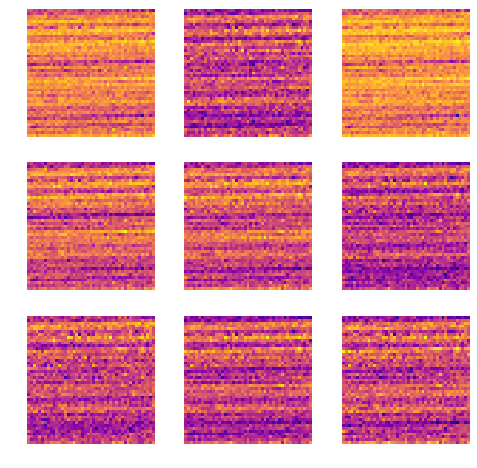

 100.0% Epoch passedNew epoch: 127
 18.17% Epoch passed

In [0]:
#TRAIN
#Create empty lists to catch losses
losses_disc, losses_generator = [], []
print_freq = 5 #fix how frequently to print losses
for epoch in range(101,201): #100 by default
    #Networks are training hence, .train()
    discriminator.train()
    generator.train()
    
#Train discriminator
    tot_inputs_passed=0
    for inputs in train_loader:
        
        #.to(device)--> work in either cpu or gpu     
        inputs = inputs.to(device) 
        
        batch_size = inputs.size(0)
        #Note: inputs.shape ->([52, 1, 28, 28])        
        #reshape to (batch_size, features) as expected by network
        real_data = inputs.view(inputs.size(0), -1) 
        
        #Flush the retained gradients
        d_optimizer.zero_grad()
        # probabilities given real data       
        pred_real = discriminator(real_data) 
        
        #Computing loss for real data         
        loss_real=criterion(pred_real, ones_or_zeros(batch_size, 1))
        
        #Note grads for gen are detached
        fake_data = generator(rand_vecs(batch_size)).detach()
 
        fake_data = fake_data.to(device)
        # probabilities given fake data
        pred_fake = discriminator(fake_data) 
        
        #Computing loss for generated data
        loss_fake=criterion(pred_fake, ones_or_zeros(batch_size, 0))
        
        loss_disc = loss_real + loss_fake  #combined loss
        losses_disc.append(loss_disc.item()) # log the losses
        #computes the gradients        
        loss_disc.backward()
        #update parameters using gradients & optimizer rules       
        d_optimizer.step()
 
        #discriminator completes a loop
#Train generator
        #Trains from scratch, newly generated data are used
        g_optimizer.zero_grad()
        #generates image/feature vector
        fake_data_new = generator(rand_vecs(batch_size))  
               
        fake_data_new = fake_data_new.to(device)
        
        pred_fake_new = discriminator(fake_data_new)
        #Generator's loss minimized after, labels are set to 1 
        loss_generator = criterion(pred_fake_new,   ones_or_zeros(batch_size, 1))
 
        losses_generator.append(loss_generator.item())
        loss_generator.backward()
        
        g_optimizer.step() #completes training loop for generator
        
        #Printing the Evolution:
        #image=generator(rand_vecs(batch_size))[0]
        #image_host=image.cpu()
        #sample=image_host.view(-1, 275).detach().numpy()
        #plt.axis('off')
        #plt.grid(b=None)
        #plt.imshow(sample)
        #plt.show()
            
        tot_inputs_passed+=1       
        
        print('\r',str(round(float(tot_inputs_passed)/len(train_loader)*100,2))+"% Epoch passed",end='')
        
#Print and save epoch, generator_state_dict as chk_point
    if epoch % print_freq ==0:
        print("loss_disc:{:.6}.., loss_generator: {:.5}".format(loss_disc, loss_generator))
        torch.save({
            'epoch': epoch,
            'gen_state_dict': generator.state_dict(),
            'dis_state_dict': discriminator.state_dict(),
            }, ('DataOutput/f_name_RawData' + '.pth'))
        torch.save({
            'epoch': epoch,
            'losses': "loss_disc:{:.6}.., loss_generator: {:.5}".format(loss_disc, loss_generator),
            }, ('DataOutput/f_name_' + str(epoch) + '.txt'))
        fig=plt.figure(figsize=(8, 8))
        columns = 3
        rows = 3
        for i in range(1, columns*rows +1):
            image=generator(rand_vecs(batch_size))[choice(range(batch_size))]
            image_host=image.cpu()
            sample=image_host.view(-1, 45).detach().numpy()
            #can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
            fig.add_subplot(rows, columns, i)
            plt.axis('off')
            plt.grid(b=None)
            im=plt.imshow(sample)
            im.set_cmap('plasma')
            plt.imsave('DataOutput/Epoch_'+str(epoch)+'_sample_'+str(i)+'.png', sample, cmap='plasma')
        plt.show()
    else:
        print("New epoch: "+str(epoch+1))

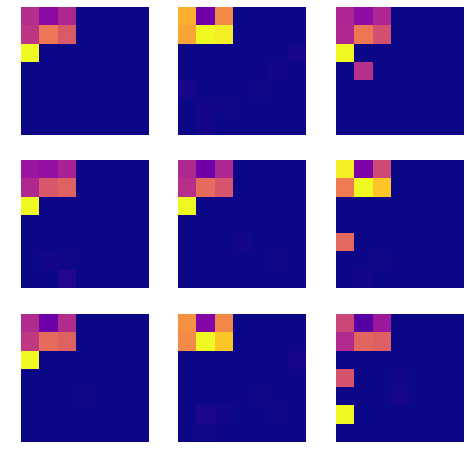

In [0]:
#Loading Images
batch=52

generator=gen_model()
generator.load_state_dict(torch.load('DataOutput/f_name_RawData.pth')['gen_state_dict'])
generator.eval()

fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    image=generator(rand_vecs(batch))[choice(range(batch))]
    image_host=image.cpu()
    sample=image_host.view(-1, 45).detach().numpy()
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.grid(b=None)
    im=plt.imshow(sample)
    im.set_cmap('plasma')
    plt.imsave('Final_Result_'+str(i)+'.png', sample, cmap='plasma')
plt.show()

In [0]:
batch=52

def remap(x):
  A=-1
  B=1
  C=1
  D=255
  
  out=(x-A)/(B-A)*(D-C)+C
  return int(out)

def remap_bin(x):
  A=-1
  B=1
  C=1
  D=255
  
  out=(x-A)/(B-A)*(D-C)+C
  
  if out<=255/2:
    out=1
  else:
    out=255
  return int(out)

output_dataframe=pd.DataFrame(columns=['Age','Sex','On_thyroxine','Query_on_thyroxine','On_antithyroid_medication','Sick','Pregnant','Thyroid_surgery','I131_treatment','Query_hypothyroid','Query_hyperthyroid','Lithium','Goitre','Tumor','Hypopituitary','Psych','TSH','T3','TT4','T4U','FTI'])
binaryVars=['Sex','On_thyroxine','Query_on_thyroxine','On_antithyroid_medication','Sick','Pregnant','Thyroid_surgery','I131_treatment','Query_hypothyroid','Query_hyperthyroid','Lithium','Goitre','Tumor','Hypopituitary','Psych']
continuousVars=['Age','TSH','T3','TT4','T4U','FTI']

generator=gen_model()
generator.load_state_dict(torch.load('DataOutput/f_name_RawData.pth')['gen_state_dict'])
generator.eval()

fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3

row=-1
for i in range(int(6330/batch)):
  for j in range(batch): 
    row+=1
    image=generator(rand_vecs(batch))[j]
    image_host=image.cpu()
    sample=image_host.view(-1, 7).detach().numpy()
    
    #plt.imshow(sample)
    
    cont_data_sample=[remap(x) for x in np.reshape(sample[:2,:3],(6))]
    binary_data_sample=[remap_bin(x) for x in np.reshape(sample[2:,:3],(15))]
    
    #print(cont_data_sample)
    #print(binary_data_sample)
    
    output_dataframe.loc[row,continuousVars]=cont_data_sample
    output_dataframe.loc[row,binaryVars]=binary_data_sample
    
    print('\r',str(row)+" rows processed",end='')

output_dataframe.to_csv('output_tyroids_data.csv')

 6319 rows processed

<Figure size 576x576 with 0 Axes>